In [1]:
# for figure 3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import lasso_path, enet_path
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel

import nbimporter
from helpers import expr_data
from helpers import scale_data
from helpers import similarity

import warnings
warnings.filterwarnings("ignore")

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

# plt.rc('legend', fontsize=SMALL_SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
import random
np.random.seed(53711)
random.seed(53711)

#### Load all data

In [4]:
data = expr_data.ExprData()
data.load_pickle()
# data = data.remove_by_wlname(['ycsb', 'xml'])
data = data.fix_tpch()
# data = data.sample_data()

#### Split by SKU

In [5]:
data_by_sku = data.split_by_sku()

In [6]:
def sparse_argsort(arr):
    indices = np.nonzero(arr)[0]
    return indices[np.argsort(arr[indices])]

In [7]:
print(list(enumerate(data_by_sku['cpu2'].wl_names)))

[(0, 'tpcc'), (1, 'tpcc'), (2, 'tpcc'), (3, 'tpcc'), (4, 'tpcc'), (5, 'tpcc'), (6, 'tpcc'), (7, 'tpcc'), (8, 'tpcc'), (9, 'tpch'), (10, 'tpch'), (11, 'tpch'), (12, 'tpch'), (13, 'tpch'), (14, 'tpch'), (15, 'tpch'), (16, 'tpch'), (17, 'tpch'), (18, 'twitter'), (19, 'twitter'), (20, 'twitter'), (21, 'twitter'), (22, 'twitter'), (23, 'twitter'), (24, 'twitter'), (25, 'twitter'), (26, 'twitter'), (27, 'ycsb'), (28, 'ycsb'), (29, 'ycsb'), (30, 'ycsb'), (31, 'ycsb'), (32, 'ycsb'), (33, 'ycsb'), (34, 'ycsb'), (35, 'ycsb')]


cpu_num=cpu16
cpu_num=cpu2
(36, 36, 29)
tpcc ['TableCardinality', 'CachedPlanSize', 'SerialDesiredMemory', 'MaxCompileMemory', 'CompileMemory', 'CPU_EFFECTIVE', 'AvgRowSize', 'CompileTime', 'CompileCPU', 'LOCK_REQ_ABS', 'StatementSubTreeCost', 'EstimateCPU', 'EstimatedAvailableMemoryGrant', 'SerialRequiredMemory', 'EstimateRows', 'StatementEstRows', 'EstimateIO', 'READ_WRITE_RATIO', 'IOPS_TOTAL', 'MEM_UTILIZATION', 'CPU_UTILIZATION', 'LOCK_WAIT_ABS', 'EstimatedRowsRead', 'EstimatedPagesCached']
tpcc ['TableCardinality', 'CachedPlanSize', 'MaxCompileMemory', 'SerialDesiredMemory', 'CompileMemory', 'AvgRowSize', 'CompileTime', 'LOCK_REQ_ABS', 'EstimatedAvailableMemoryGrant', 'CompileCPU', 'StatementSubTreeCost', 'EstimateCPU', 'EstimateRows', 'SerialRequiredMemory', 'CPU_EFFECTIVE', 'StatementEstRows', 'READ_WRITE_RATIO', 'EstimateIO', 'IOPS_TOTAL', 'MEM_UTILIZATION', 'LOCK_WAIT_ABS', 'CPU_UTILIZATION', 'EstimatedRowsRead']
tpch ['EstimateCPU', 'READ_WRITE_RATIO', 'MaxCompileMemory', 'St

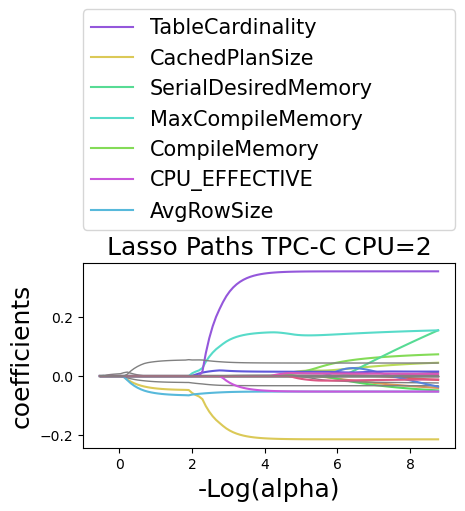

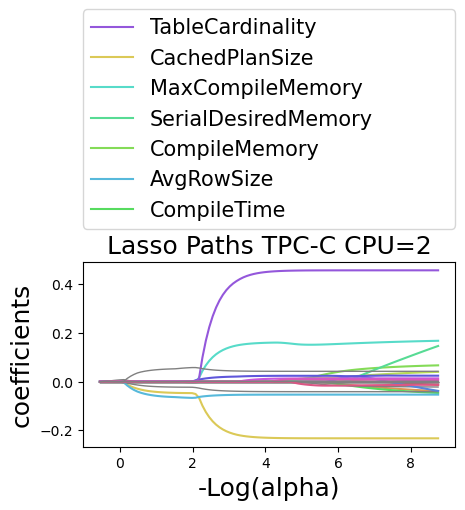

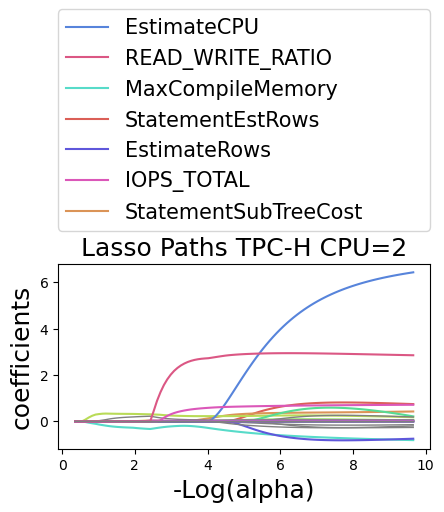

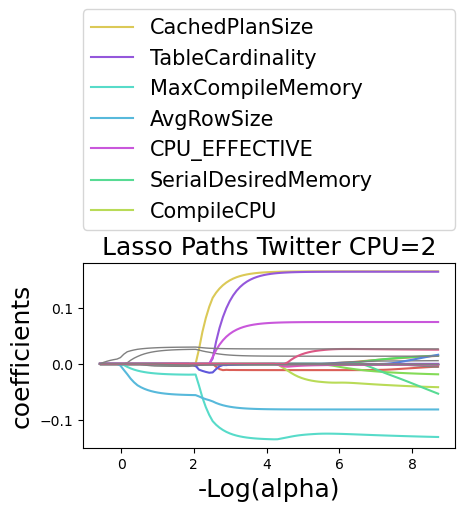

cpu_num=cpu4
cpu_num=cpu8


In [18]:
NUM_FEATURE = 7
for sku in data_by_sku.keys():
    curr_data = data_by_sku[sku]
    print(f'cpu_num={sku}')
    if 'cpu2' not in sku:
        continue
    if 'ter' in sku:
        continue
    scaler = scale_data.ScaleData()
    plan_mtxs_splitted, plan_col_ranges = scaler.scale(curr_data.plan_mtxs)
    perf_mtxs_splitted, perf_col_ranges = scaler.scale(curr_data.perf_mtxs)
    # print(perf_col_ranges)
    # print(perf_mtxs_splitted[0][:,4])
    simi_calc = similarity.Similarity(curr_data, plan_mtxs_splitted, plan_col_ranges, perf_mtxs_splitted, perf_col_ranges, num_bins=10)
    simi_calc.calc_bined_mtx()
    simi_calc.calc_dist_simi_matrix()
    
    # for some experiment, its distanct to others are: 
    expr_idx = 0
    # print(simi_calc.plan_dist_mtx[0])
    
    # feature wise distance
    simi_calc.calc_featurewise_dist_by_col()
    
    # expr_num = curr_data.get_num_exprs()
    expr_num = 4
    out_exprs = [1, 2, 17, 20]
    # out_exprs = list(range(36)) 
    sku_dict = {}

    display_features = []
    for expr_idx, i in zip(out_exprs, list(range(expr_num))):
        # calculate label
        curr_name = curr_data.wl_names[expr_idx]
        y = [curr_name == name for name in curr_data.wl_names]
        # X = simi_calc.plan_dist_by_col_cube[i]
        X = simi_calc.simi_col_mtx[expr_idx]
    
        eps = 5e-10  # the smaller it is the longer is the path
        alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=10000)

        neg_log_alphas_lasso = -np.log10(alphas_lasso)
        weights = np.array([-1*abs(coef_l[-1]) for coef_l in coefs_lasso])

        orders = sparse_argsort(weights)
        feature_importance = [curr_data.feature_cols[j] for j in orders]
        print(curr_name, feature_importance)
        sku_dict[curr_name+str(i)] = {
            'weights': weights,
            'orders': orders,
            'fi': feature_importance,
            'alphas': neg_log_alphas_lasso,
            'lassos': coefs_lasso
        }
        display_features += list(orders[:NUM_FEATURE])
        
    display_features = np.unique(display_features)
    colors = sns.color_palette("hls", len(display_features))

    for expr_idx, i in zip(out_exprs, list(range(expr_num))):
        curr_name = curr_data.wl_names[expr_idx]
                    
        if curr_name == 'tpcc':
            title_name = 'TPC-C'
        elif curr_name == 'tpch':
            title_name = 'TPC-H'
        elif curr_name == 'twitter':
            title_name = 'Twitter';
        curr_name = curr_name+str(i)

        fig, ax = plt.subplots(figsize=(4.8, 2.4))
        # fig, ax = plt.subplots(figsize=(6, 2.4))
        for idx, coef_l in zip(list(range(len(curr_data.feature_cols))), sku_dict[curr_name]['lassos']):
            if idx in display_features:
                # get index 
                c_idx = np.where(display_features==idx)[0][0]
                l1 = ax.plot(sku_dict[curr_name]['alphas'], coef_l, c=colors[c_idx], label=curr_data.feature_cols[idx])
            else:
                l1 = ax.plot(sku_dict[curr_name]['alphas'], coef_l, c='gray', linewidth=1, label=curr_data.feature_cols[idx])

        ax.set_title('Lasso Paths {} CPU={}'.format(title_name, int(sku[3:])))#, fontsize=14)

        handles, labels = ax.get_legend_handles_labels()
        handles = [handles[j] for j in sku_dict[curr_name]['orders']][:NUM_FEATURE]
        labels = [labels[j] for j in sku_dict[curr_name]['orders']][:NUM_FEATURE]

        # ax.legend(handles,labels,bbox_to_anchor=(-0.15, 1.15, 1.15, .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0., fontsize=11) # 
        ax.legend(handles,labels,bbox_to_anchor=(0, 1.18, 1, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)#, fontsize=11) # 
        ax.set_xlabel('-Log(alpha)')#, fontsize=12)
        ax.set_ylabel('coefficients')#, fontsize=12)
        ax.tick_params(axis='both', which='major')#, labelsize=10)

        plt.savefig(f'../figs/short_{curr_name}_lasso_path{NUM_FEATURE}_{sku}_fs.pdf', bbox_inches="tight")
        plt.show()

cpu_num=cpu16
cpu_num=cpu2
(36, 36, 29)
tpcc ['TableCardinality', 'CachedPlanSize', 'SerialDesiredMemory', 'MaxCompileMemory', 'CompileMemory', 'CPU_EFFECTIVE', 'AvgRowSize', 'CompileTime', 'CompileCPU', 'LOCK_REQ_ABS', 'StatementSubTreeCost', 'EstimateCPU', 'EstimatedAvailableMemoryGrant', 'SerialRequiredMemory', 'EstimateRows', 'StatementEstRows', 'EstimateIO', 'READ_WRITE_RATIO', 'IOPS_TOTAL', 'MEM_UTILIZATION', 'CPU_UTILIZATION', 'LOCK_WAIT_ABS', 'EstimatedRowsRead', 'EstimatedPagesCached']
tpcc ['TableCardinality', 'CachedPlanSize', 'MaxCompileMemory', 'SerialDesiredMemory', 'CompileMemory', 'AvgRowSize', 'CompileTime', 'LOCK_REQ_ABS', 'EstimatedAvailableMemoryGrant', 'CompileCPU', 'StatementSubTreeCost', 'EstimateCPU', 'EstimateRows', 'SerialRequiredMemory', 'CPU_EFFECTIVE', 'StatementEstRows', 'READ_WRITE_RATIO', 'EstimateIO', 'IOPS_TOTAL', 'MEM_UTILIZATION', 'LOCK_WAIT_ABS', 'CPU_UTILIZATION', 'EstimatedRowsRead']
tpch ['EstimateCPU', 'READ_WRITE_RATIO', 'MaxCompileMemory', 'St

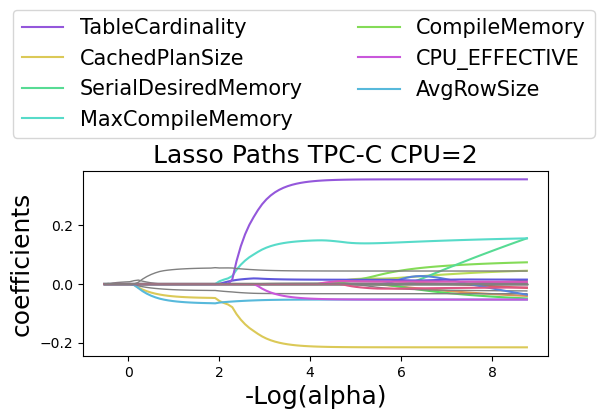

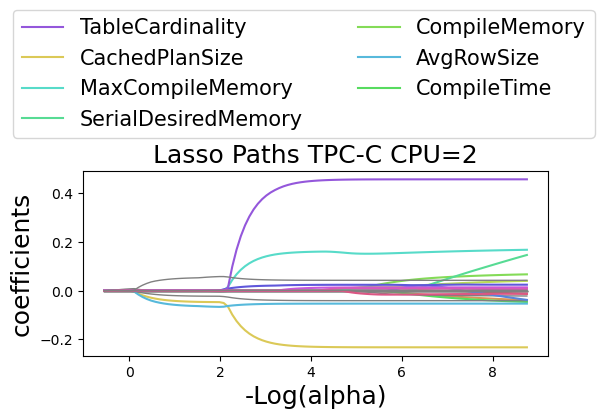

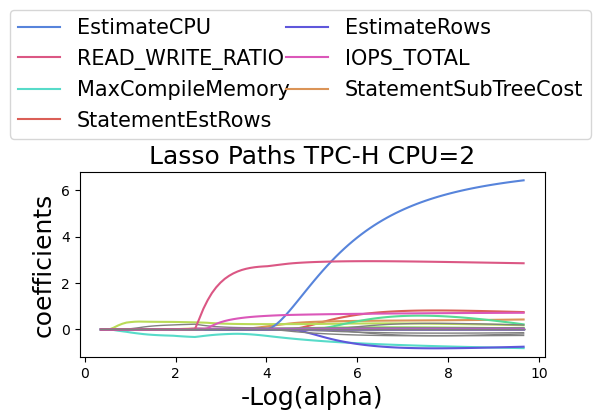

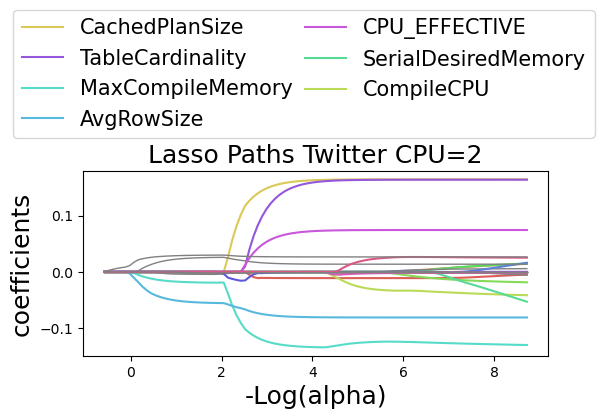

cpu_num=cpu4
cpu_num=cpu8


In [17]:
NUM_FEATURE = 7
for sku in data_by_sku.keys():
    curr_data = data_by_sku[sku]
    print(f'cpu_num={sku}')
    if 'cpu2' not in sku:
        continue
    if 'ter' in sku:
        continue
    scaler = scale_data.ScaleData()
    plan_mtxs_splitted, plan_col_ranges = scaler.scale(curr_data.plan_mtxs)
    perf_mtxs_splitted, perf_col_ranges = scaler.scale(curr_data.perf_mtxs)
    # print(perf_col_ranges)
    # print(perf_mtxs_splitted[0][:,4])
    simi_calc = similarity.Similarity(curr_data, plan_mtxs_splitted, plan_col_ranges, perf_mtxs_splitted, perf_col_ranges, num_bins=10)
    simi_calc.calc_bined_mtx()
    simi_calc.calc_dist_simi_matrix()
    
    # for some experiment, its distanct to others are: 
    expr_idx = 0
    # print(simi_calc.plan_dist_mtx[0])
    
    # feature wise distance
    simi_calc.calc_featurewise_dist_by_col()
    
    # expr_num = curr_data.get_num_exprs()
    expr_num = 4
    out_exprs = [1, 2, 17, 20]
    # out_exprs = list(range(36)) 
    sku_dict = {}

    display_features = []
    for expr_idx, i in zip(out_exprs, list(range(expr_num))):
        # calculate label
        curr_name = curr_data.wl_names[expr_idx]
        y = [curr_name == name for name in curr_data.wl_names]
        # X = simi_calc.plan_dist_by_col_cube[i]
        X = simi_calc.simi_col_mtx[expr_idx]
    
        eps = 5e-10  # the smaller it is the longer is the path
        alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=10000)

        neg_log_alphas_lasso = -np.log10(alphas_lasso)
        weights = np.array([-1*abs(coef_l[-1]) for coef_l in coefs_lasso])

        orders = sparse_argsort(weights)
        feature_importance = [curr_data.feature_cols[j] for j in orders]
        print(curr_name, feature_importance)
        sku_dict[curr_name+str(i)] = {
            'weights': weights,
            'orders': orders,
            'fi': feature_importance,
            'alphas': neg_log_alphas_lasso,
            'lassos': coefs_lasso
        }
        display_features += list(orders[:NUM_FEATURE])
        
    display_features = np.unique(display_features)
    colors = sns.color_palette("hls", len(display_features))

    for expr_idx, i in zip(out_exprs, list(range(expr_num))):
        curr_name = curr_data.wl_names[expr_idx]
                    
        if curr_name == 'tpcc':
            title_name = 'TPC-C'
        elif curr_name == 'tpch':
            title_name = 'TPC-H'
        elif curr_name == 'twitter':
            title_name = 'Twitter';
        curr_name = curr_name+str(i)

        # fig, ax = plt.subplots(figsize=(4.8, 3.2))
        fig, ax = plt.subplots(figsize=(6, 2.4))
        for idx, coef_l in zip(list(range(len(curr_data.feature_cols))), sku_dict[curr_name]['lassos']):
            if idx in display_features:
                # get index 
                c_idx = np.where(display_features==idx)[0][0]
                l1 = ax.plot(sku_dict[curr_name]['alphas'], coef_l, c=colors[c_idx], label=curr_data.feature_cols[idx])
            else:
                l1 = ax.plot(sku_dict[curr_name]['alphas'], coef_l, c='gray', linewidth=1, label=curr_data.feature_cols[idx])

        ax.set_title('Lasso Paths {} CPU={}'.format(title_name, int(sku[3:])))#, fontsize=14)

        handles, labels = ax.get_legend_handles_labels()
        handles = [handles[j] for j in sku_dict[curr_name]['orders']][:NUM_FEATURE]
        labels = [labels[j] for j in sku_dict[curr_name]['orders']][:NUM_FEATURE]

        # ax.legend(handles,labels,bbox_to_anchor=(-0.15, 1.15, 1.15, .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0., fontsize=11) # 
        ax.legend(handles,labels,bbox_to_anchor=(-0.15, 1.18, 1.25, .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)#, fontsize=11) # 
        ax.set_xlabel('-Log(alpha)')#, fontsize=12)
        ax.set_ylabel('coefficients')#, fontsize=12)
        ax.tick_params(axis='both', which='major')#, labelsize=10)

        plt.savefig(f'../figs/short_2col_{curr_name}_lasso_path{NUM_FEATURE}_{sku}_fs.pdf', bbox_inches="tight")
        plt.show()

#### Calculate similarity

In [9]:
# fs_dict = {}
# NUM_FEATURE = 7
# expr_num = 4
# # corresponding to 16, 2, 4, 8
# fig_pos = [3, 0, 1, 2]
# i = 0
# for sku in data_by_sku.keys():
#     curr_data = data_by_sku[sku]
#     print(f'cpu_num={sku}')
#     if 'ter' in sku:
#         continue
#     scaler = scale_data.ScaleData()
#     plan_mtxs_splitted, plan_col_ranges = scaler.scale(curr_data.plan_mtxs)
#     perf_mtxs_splitted, perf_col_ranges = scaler.scale(curr_data.perf_mtxs)

#     simi_calc = similarity.Similarity(curr_data, plan_mtxs_splitted, plan_col_ranges, perf_mtxs_splitted, perf_col_ranges, num_bins=10)
#     simi_calc.calc_bined_mtx()
#     simi_calc.calc_dist_simi_matrix()
    
#     # for some experiment, its distanct to others are: 
#     expr_idx = 0
    
#     # feature wise distance
#     simi_calc.calc_featurewise_dist_by_col()

#     fig, ax = plt.subplots()
#     # calculate label
#     curr_name = curr_data.wl_names[expr_idx]
#     if curr_name == 'tpcc':
#         title_name = 'TPC-C'
#     else:
#         continue
#     y = [curr_name == name for name in curr_data.wl_names]
#     X = simi_calc.simi_col_mtx[expr_idx]

#     eps = 5e-10  # the smaller it is the longer is the path
#     alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=100000000)
#     # alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=10000)
#     colors = sns.color_palette("hls", len(curr_data.feature_cols))
#     last_coefs = coefs_lasso[:, -1] 
#     remaining_idx = np.nonzero(last_coefs)

#     neg_log_alphas_lasso = -np.log10(alphas_lasso)
#     weights = []
#     for idx, coef_l, c in zip(list(range(len(curr_data.feature_cols))), coefs_lasso, colors):
#         weights.append(-1*abs(coef_l[-1]))
#         # if coef_l[-1] == 0:
#         #     l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c)
#         # else:
#         #     l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c, label=curr_data.feature_cols[idx])
#         #     # ax.legend()
#         l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c, label=curr_data.feature_cols[idx])

    
#     ax.set_title('CPU={}'.format(int(sku[3:])))
#     weights = np.array(weights)
#     orders = sparse_argsort(weights)
#     feature_importance = [curr_data.feature_cols[j] for j in orders]
#     print(curr_name, feature_importance)

#     handles, labels = ax.get_legend_handles_labels()
#     handles = [handles[j] for j in orders][:NUM_FEATURE]
#     labels = [labels[j] for j in orders][:NUM_FEATURE]

#     # ax.legend(handles,labels,loc='best')
#     ax.legend(handles,labels,bbox_to_anchor=(-0.05, 1.15, 1.1, .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0., fontsize=9) # 
#     i += 1
#     ax.set_xlabe('-Log(alpha)')
#     plt.savefig(f'../figs/subset_lasso_path{NUM_FEATURE}_{curr_name}_fs.pdf',  bbox_inches="tight")
#     plt.show()
        
# fig.text(0.5, 0.01, '-Log(alpha)', ha='center', fontsize=10)
# fig.text(0.085, 0.5, 'coefficients', va='center', rotation='vertical', fontsize=10)
# plt.suptitle("Lasso Paths TPC-C")
# # plt.axis("tight")
# plt.savefig(f'../figs/subset_lasso_path{NUM_FEATURE}_{curr_name}_fs.pdf',  bbox_inches="tight")
# plt.show()


In [10]:
# fs_dict = {}
# NUM_FEATURE = 7
# expr_num = 4
# fig, axs = plt.subplots(nrows=1, ncols=expr_num, figsize=(20, 4))
# ax_list = axs.reshape(-1)
# # corresponding to 16, 2, 4, 8
# fig_pos = [3, 0, 1, 2]
# i = 0
# expr_idx = 6

# for sku in data_by_sku.keys():
#     curr_data = data_by_sku[sku]
#     print(f'cpu_num={sku}')
#     if 'ter' in sku:
#         continue
#     scaler = scale_data.ScaleData()
#     plan_mtxs_splitted, plan_col_ranges = scaler.scale(curr_data.plan_mtxs)
#     perf_mtxs_splitted, perf_col_ranges = scaler.scale(curr_data.perf_mtxs)

#     simi_calc = similarity.Similarity(curr_data, plan_mtxs_splitted, plan_col_ranges, perf_mtxs_splitted, perf_col_ranges, num_bins=10)
#     simi_calc.calc_bined_mtx()
#     simi_calc.calc_dist_simi_matrix()
    
#     # for some experiment, its distanct to others are: 
#     # print(simi_calc.plan_dist_mtx[0])
    
#     # feature wise distance
#     simi_calc.calc_featurewise_dist_by_col()

#     ax = ax_list[fig_pos[i]]
#     # calculate label
#     curr_name = curr_data.wl_names[expr_idx]
#     if curr_name == 'twitter':
#         title_name = 'Twitter'
#     else:
#         continue
#     y = [curr_name == name for name in curr_data.wl_names]
#     X = simi_calc.dist_by_col_cube[expr_idx]

#     eps = 5e-10  # the smaller it is the longer is the path
#     alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=100000000)
#     # alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=10000)
#     colors = sns.color_palette("hls", len(curr_data.feature_cols))
#     last_coefs = coefs_lasso[:, -1] 
#     remaining_idx = np.nonzero(last_coefs)

#     neg_log_alphas_lasso = -np.log10(alphas_lasso)
#     weights = []
#     for idx, coef_l, c in zip(list(range(len(curr_data.feature_cols))), coefs_lasso, colors):
#         weights.append(-1*abs(coef_l[-1]))
#         # if coef_l[-1] == 0:
#         #     l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c)
#         # else:
#         #     l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c, label=curr_data.feature_cols[idx])
#         #     # ax.legend()
#         l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c, label=curr_data.feature_cols[idx])

    
#     ax.set_title('CPU={}'.format(int(sku[3:])))
#     weights = np.array(weights)
#     orders = sparse_argsort(weights)
#     feature_importance = [curr_data.feature_cols[j] for j in orders]
#     print(curr_name, feature_importance)

#     handles, labels = ax.get_legend_handles_labels()
#     handles = [handles[j] for j in orders][:NUM_FEATURE]
#     labels = [labels[j] for j in orders][:NUM_FEATURE]

#     # ax.legend(handles,labels,loc='best')
#     ax.legend(handles,labels,bbox_to_anchor=(-0.05, 1.15, 1.1, .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0., fontsize=9) # 
#     i += 1
        
# fig.text(0.5, 0.01, '-Log(alpha)', ha='center', fontsize=10)
# fig.text(0.085, 0.5, 'coefficients', va='center', rotation='vertical', fontsize=10)
# plt.suptitle("Lasso Paths {}".format(title_name))
# # plt.axis("tight")
# plt.savefig(f'../figs/subset_lasso_path{NUM_FEATURE}_{curr_name}_fs.pdf',  bbox_inches="tight")
# plt.show()


In [11]:
# fs_dict = {}
# NUM_FEATURE = 7
# expr_num = 4
# fig, axs = plt.subplots(nrows=1, ncols=expr_num, figsize=(20, 4))
# ax_list = axs.reshape(-1)
# # corresponding to 16, 2, 4, 8
# fig_pos = [3, 0, 1, 2]
# i = 0
# expr_idx = 3

# for sku in data_by_sku.keys():
#     curr_data = data_by_sku[sku]
#     print(f'cpu_num={sku}')
#     if 'ter' in sku:
#         continue
#     scaler = scale_data.ScaleData()
#     plan_mtxs_splitted, plan_col_ranges = scaler.scale(curr_data.plan_mtxs)
#     perf_mtxs_splitted, perf_col_ranges = scaler.scale(curr_data.perf_mtxs)

#     simi_calc = similarity.Similarity(curr_data, plan_mtxs_splitted, plan_col_ranges, perf_mtxs_splitted, perf_col_ranges, num_bins=10)
#     simi_calc.calc_bined_mtx()
#     simi_calc.calc_dist_simi_matrix()
    
#     # for some experiment, its distanct to others are: 
#     # print(simi_calc.plan_dist_mtx[0])
    
#     # feature wise distance
#     simi_calc.calc_featurewise_dist_by_col()

#     ax = ax_list[fig_pos[i]]
#     # calculate label
#     curr_name = curr_data.wl_names[expr_idx]
#     if curr_name == 'tpch':
#         title_name = 'TPC-H'
#     else:
#         continue
#     y = [curr_name == name for name in curr_data.wl_names]
#     X = simi_calc.dist_by_col_cube[expr_idx]

#     eps = 5e-10  # the smaller it is the longer is the path
#     alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=100000000)
#     # alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=10000)
#     colors = sns.color_palette("hls", len(curr_data.feature_cols))
#     last_coefs = coefs_lasso[:, -1] 
#     remaining_idx = np.nonzero(last_coefs)

#     neg_log_alphas_lasso = -np.log10(alphas_lasso)
#     weights = []
#     for idx, coef_l, c in zip(list(range(len(curr_data.feature_cols))), coefs_lasso, colors):
#         weights.append(-1*abs(coef_l[-1]))
#         # if coef_l[-1] == 0:
#         #     l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c)
#         # else:
#         #     l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c, label=curr_data.feature_cols[idx])
#         #     # ax.legend()
#         l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c, label=curr_data.feature_cols[idx])

    
#     ax.set_title('CPU={}'.format(int(sku[3:])))
#     weights = np.array(weights)
#     orders = sparse_argsort(weights)
#     feature_importance = [curr_data.feature_cols[j] for j in orders]
#     print(curr_name, feature_importance)

#     handles, labels = ax.get_legend_handles_labels()
#     handles = [handles[j] for j in orders][:NUM_FEATURE]
#     labels = [labels[j] for j in orders][:NUM_FEATURE]

#     # ax.legend(handles,labels,loc='best')
#     ax.legend(handles,labels,bbox_to_anchor=(-0.05, 1.15, 1.1, .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0., fontsize=9) # 
#     i += 1
        
# fig.text(0.5, 0.01, '-Log(alpha)', ha='center', fontsize=10)
# fig.text(0.085, 0.5, 'coefficients', va='center', rotation='vertical', fontsize=10)
# plt.suptitle("Lasso Paths {}".format(title_name))
# # plt.axis("tight")
# plt.savefig(f'../figs/subset_lasso_path{NUM_FEATURE}_{curr_name}_fs.pdf',  bbox_inches="tight")
# plt.show()


In [12]:
# fs_dict = {}
# NUM_FEATURE = 7
# for sku in data_by_sku.keys():
#     curr_data = data_by_sku[sku]
#     print(f'cpu_num={sku}')
#     if 'ter' in sku:
#         continue
#     scaler = scale_data.ScaleData()
#     plan_mtxs_splitted, plan_col_ranges = scaler.scale(curr_data.plan_mtxs)
#     perf_mtxs_splitted, perf_col_ranges = scaler.scale(curr_data.perf_mtxs)
#     # print(perf_col_ranges)
#     # print(perf_mtxs_splitted[0][:,4])
#     simi_calc = similarity.Similarity(curr_data, plan_mtxs_splitted, plan_col_ranges, perf_mtxs_splitted, perf_col_ranges, num_bins=10)
#     simi_calc.calc_bined_mtx()
#     simi_calc.calc_dist_simi_matrix()
    
#     # for some experiment, its distanct to others are: 
#     expr_idx = 0
#     # print(simi_calc.plan_dist_mtx[0])
    
#     # feature wise distance
#     simi_calc.calc_featurewise_dist_by_col()
    
#     expr_num = curr_data.get_num_exprs()
#     # fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True,figsize=(20, 20))
#     fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True,figsize=(20, 20))
#     ax_list = axs.reshape(-1)
    
#     sku_dict = {}

#     for i in range(expr_num):
#         ax = ax_list[i]
#         # calculate label
#         curr_name = curr_data.wl_names[i]
#         y = [curr_name == name for name in curr_data.wl_names]
#         # X = simi_calc.plan_dist_by_col_cube[i]
#         X = simi_calc.dist_by_col_cube[i]
    
#         eps = 5e-10  # the smaller it is the longer is the path
#         alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=100000000)
#         # alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=10000)
#         colors = sns.color_palette("hls", len(curr_data.feature_cols))
#         last_coefs = coefs_lasso[:, -1] 
#         remaining_idx = np.nonzero(last_coefs)

#         neg_log_alphas_lasso = -np.log10(alphas_lasso)
#         weights = []
#         for idx, coef_l, c in zip(list(range(len(curr_data.feature_cols))), coefs_lasso, colors):
#             weights.append(-1*abs(coef_l[-1]))
#             # if coef_l[-1] == 0:
#             #     l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c)
#             # else:
#             #     l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c, label=curr_data.feature_cols[idx])
#             #     # ax.legend()
#             l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c, label=curr_data.feature_cols[idx])
#         ax.set_title('Workload {}'.format(curr_name))
#         weights = np.array(weights)
#         orders = sparse_argsort(weights)
#         feature_importance = [curr_data.feature_cols[j] for j in orders]
#         print(curr_name, feature_importance)
        
#         handles, labels = ax.get_legend_handles_labels()
#         handles = [handles[j] for j in orders][:NUM_FEATURE]
#         labels = [labels[j] for j in orders][:NUM_FEATURE]

#         ax.legend(handles,labels,loc='best')
#         sku_dict[curr_name+str(i)] = feature_importance
        
#     fig.text(0.5, 0.04, '-Log(alpha)', ha='center')
#     fig.text(0.04, 0.5, 'coefficients', va='center', rotation='vertical')
#     # plt.suptitle("Lasso Paths CPU={}".format(sku))
#     plt.axis("tight")
#     plt.savefig(f'../figs/lasso_path{NUM_FEATURE}_{sku}_fs.pdf')
#     plt.show()
#     fs_dict[sku] = sku_dict

In [13]:
# fs_dict = {}
# NUM_FEATURE = 7
# for sku in data_by_sku.keys():
#     curr_data = data_by_sku[sku]
#     print(f'cpu_num={sku}')
#     if 'ter' in sku:
#         continue
#     scaler = scale_data.ScaleData()
#     plan_mtxs_splitted, plan_col_ranges = scaler.scale(curr_data.plan_mtxs)
#     perf_mtxs_splitted, perf_col_ranges = scaler.scale(curr_data.perf_mtxs)
#     # print(perf_col_ranges)
#     # print(perf_mtxs_splitted[0][:,4])
#     simi_calc = similarity.Similarity(curr_data, plan_mtxs_splitted, plan_col_ranges, perf_mtxs_splitted, perf_col_ranges, num_bins=10)
#     simi_calc.calc_bined_mtx()
#     simi_calc.calc_dist_simi_matrix()
    
#     # for some experiment, its distanct to others are: 
#     expr_idx = 0
#     # print(simi_calc.plan_dist_mtx[0])
    
#     # feature wise distance
#     simi_calc.calc_featurewise_dist_by_col()
    
#     expr_num = curr_data.get_num_exprs()
#     # fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True,figsize=(20, 20))
#     fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True,figsize=(20, 20))
#     ax_list = axs.reshape(-1)
    
#     sku_dict = {}

#     for i in range(expr_num):
#         ax = ax_list[i]
#         # calculate label
#         curr_name = curr_data.wl_names[i]
#         y = [curr_name == name for name in curr_data.wl_names]
#         # X = simi_calc.plan_dist_by_col_cube[i]
#         X = simi_calc.dist_by_col_cube[i]
    
#         eps = 5e-10  # the smaller it is the longer is the path
#         alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=100000000)
#         # alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=10000)
#         colors = sns.color_palette("hls", len(curr_data.feature_cols))
#         last_coefs = coefs_lasso[:, -1] 
#         remaining_idx = np.nonzero(last_coefs)

#         neg_log_alphas_lasso = -np.log10(alphas_lasso)
#         weights = []
#         for idx, coef_l, c in zip(list(range(len(curr_data.feature_cols))), coefs_lasso, colors):
#             weights.append(-1*abs(coef_l[-1]))
#             # if coef_l[-1] == 0:
#             #     l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c)
#             # else:
#             #     l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c, label=curr_data.feature_cols[idx])
#             #     # ax.legend()
#             l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c, label=curr_data.feature_cols[idx])
#         ax.set_title('Workload {}'.format(curr_name))
#         weights = np.array(weights)
#         orders = sparse_argsort(weights)
#         feature_importance = [curr_data.feature_cols[j] for j in orders]
#         print(curr_name, feature_importance)
        
#         handles, labels = ax.get_legend_handles_labels()
#         handles = [handles[j] for j in orders][:NUM_FEATURE]
#         labels = [labels[j] for j in orders][:NUM_FEATURE]

#         ax.legend(handles,labels,loc='best')
#         sku_dict[curr_name+str(i)] = feature_importance
        
#     fig.text(0.5, 0.04, '-Log(alpha)', ha='center')
#     fig.text(0.04, 0.5, 'coefficients', va='center', rotation='vertical')
#     # plt.suptitle("Lasso Paths CPU={}".format(sku))
#     plt.axis("tight")
#     plt.savefig(f'../figs/lasso_path{NUM_FEATURE}_{sku}_fs.pdf')
#     plt.show()
#     fs_dict[sku] = sku_dict

In [14]:
for sku in data_by_sku.keys():
    curr_data = data_by_sku[sku]
    print(f'cpu_num={sku}')
    scaler = scale_data.ScaleData()
    plan_mtxs_splitted, col_ranges = scaler.scale(curr_data.plan_mtxs)
    perf_mtxs_splitted, perf_col_ranges = scaler.scale(curr_data.perf_mtxs)
    simi_calc = similarity.Similarity(curr_data, plan_mtxs_splitted, plan_col_ranges, perf_mtxs_splitted, perf_col_ranges, num_bins=10)
    simi_calc.calc_bined_mtx()
    simi_calc.calc_dist_simi_matrix(plan_only=True)
    
    # for some experiment, its distanct to others are: 
    expr_idx = 0
    
    # feature wise distance
    simi_calc.calc_featurewise_dist_by_col(plan_only=True)
    
    expr_num = curr_data.get_num_exprs()
    fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True,figsize=(20, 20))
    ax_list = axs.reshape(-1)

    for i in range(expr_num):
        ax = ax_list[i]
        # calculate label
        curr_name = curr_data.wl_names[i]
        y = [curr_name == name for name in curr_data.wl_names]
        X = simi_calc.plan_dist_by_col_cube[i]
        
        eps = 5e-10  # the smaller it is the longer is the path
        alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, max_iter=100000000)
        # alphas_lasso, coefs_lasso, _ = lasso_path(X, y, max_iter=10000)
        colors = sns.color_palette("hls", len(curr_data.plan_feature_cols))
        last_coefs = coefs_lasso[:, -1] 
        remaining_idx = np.nonzero(last_coefs)
        
        neg_log_alphas_lasso = -np.log10(alphas_lasso)
        weights = []
        for idx, coef_l, c in zip(list(range(len(curr_data.plan_feature_cols))), coefs_lasso, colors):
            weights.append(-1*abs(coef_l[-1]))

            if coef_l[-1] == 0:
                l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c)
            else:
                l1 = ax.plot(neg_log_alphas_lasso, coef_l, c=c, label=curr_data.plan_feature_cols[idx])
                ax.legend()
            ax.set_title('Workload {}'.format(curr_name))
        weights = np.array(weights)
        orders = sparse_argsort(weights)
        feature_importance = [curr_data.plan_feature_cols[j] for j in orders]
        print(curr_name, feature_importance)
        
    fig.text(0.5, 0.04, '-Log(alpha)', ha='center')
    fig.text(0.04, 0.5, 'coefficients', va='center', rotation='vertical')
    plt.suptitle("Lasso Paths CPU={}".format(sku))
    plt.axis("tight")
    plt.show()
    # break

cpu_num=cpu16


TypeError: calc_dist_simi_matrix() got an unexpected keyword argument 'plan_only'